# Multi-Component 2-D Gaussian Fitting — Tutorial

Dave Mehringer, 2025 September

This notebook demonstrates the major features of:

- `astroviper.fitting.multi_gaussian2d_fit.fit_multi_gaussian2d`
- `astroviper.fitting.multi_gaussian2d_fit.plot_components` (if available)

You’ll learn how to:
- Fit one or many 2-D Gaussians (sum of components) to images or data cubes
- Use NumPy, Dask, or Xarray inputs and vectorize over extra dims
- Provide initial guesses (array / list-of-dicts / dict-with-components)
- Apply bounds (including fixing parameters with equal bounds)
- Use thresholds to mask pixels during the fit
- Work with angle conventions: `"math"`, `"pa"`, and `"auto"`
- Get world coordinates of centroids when axis coords are provided
- Return fitted model plane(s) and residuals

**Tip:** Run cells top-to-bottom. All cells are self-contained and documented.

## Imports & Utilities

In [1]:
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt

from astroviper.fitting.multi_gaussian2d_fit import fit_multi_gaussian2d
from astroviper.model.component_models import make_gauss2d

from astroviper.fitting.multi_gaussian2d_fit import plot_components
from astroviper.utils.plotting import plot_correct_orientation

# Reproducibility
rng = np.random.default_rng(1234)

### Utility: synthetic Gaussian scenes
Helpers used only to generate synthetic test images for this tutorial.

In [2]:
def make_scene_via_component_models(
    ny: int,
    nx: int,
    components: list[dict],
    *,
    offset: float = 0.1,
    noise_std: float = 0.02,
    seed: int | None = None,
    coords: bool = True,
    angle: str = "math",  # "math" | "pa" | "auto" — same semantics as astroviper's model
    x_world: tuple[float, float] = (0.0, 1.0),
    y_world: tuple[float, float] = (0.0, 1.0),
) -> xr.DataArray:
    """
    Build a synthetic image using astroviper.model.component_models.(make_gaussian|make_gauss2d).

    components: list of dicts with keys:
      {"amp"/"amplitude","x0","y0","sigma_x","sigma_y","theta"}.
    """
    rng = np.random.default_rng(seed)

    nchan = 1 if isinstance(components[0], dict) else len(components)
    
    # coords
    if coords:
        x0, x1 = x_world
        y0, y1 = y_world
        x = np.linspace(x0, x1, nx, dtype=float)
        y = np.linspace(y0, y1, ny, dtype=float)
    else:
        x = np.arange(nx, dtype=float)
        y = np.arange(ny, dtype=float)
    # accumulate model in float64
    if nchan == 1:
        components = [components.copy()]
    z = np.zeros((ny, nx, nchan), dtype=float)
    print("components", components, type(components))
    for i in range(nchan):
        plane_components = components[i]
        for c in plane_components:
            print("plane component", c, type(c))
            amp = float(c.get("amp", c.get("amplitude")))
            x0c = float(c["x0"])
            y0c = float(c["y0"])
            fwhm_x = float(c["fwhm_major"])
            fwhm_y = float(c["fwhm_minor"])
            thc = float(c.get("theta", 0.0))

            # astroviper's generator uses coords + angle convention, returns (ny,nx)
            z[:,:,i] = make_gauss2d(
                data=z[..., i],
                a=fwhm_x,
                b=fwhm_y,
                theta=thc,
                x0=x0c,
                y0=y0c,
                peak=amp,
                x_coord="x",
                y_coord="y",
                coords={"x": x, "y": y},
                add=True,
                angle=angle,
            )
    if nchan == 1:
        z = np.squeeze(z, axis=2)

    z += float(offset)
    if noise_std > 0:
        z += rng.normal(scale=noise_std, size=z.shape)

    dims = ("y", "x") if nchan == 1 else ("y", "x", "z")
    print("shape z", z.shape, "dims", dims)
    da = xr.DataArray(z, dims=dims)
    print("da shape", da.shape)
    if coords:
        vals = dict(x=x, y=y) if nchan == 1 else dict(x=x, y=y, z=np.array((2, 4), dtype=float))
        da = da.assign_coords(vals)
    return da

### Get array min/max

In [3]:
def minmax(a, dim=None, skipna=True, compute=True):
    """
    Return (vmin, vmax) for NumPy ndarray, Dask array, or xarray.DataArray.

    Parameters
    ----------
    a : np.ndarray | dask.array.Array | xarray.DataArray
    dim : axis or sequence of axes (NumPy/Dask) or dim name(s) (xarray)
    skipna : bool
        If True, ignore NaNs (uses nanmin/nanmax where appropriate).
    compute : bool
        If True, trigger computation for Dask/xarray and return concrete results.
        If False, return lazy objects (Dask arrays or xarray objects).

    Notes
    -----
    - For xarray, dim should be a dimension name or list/tuple of names.
    - For NumPy/Dask, dim is passed to the `axis` argument (can be int or tuple).
    """
    # xarray.DataArray (NumPy- or Dask-backed)
    if isinstance(a, xr.DataArray):
        vmin = a.min(dim=dim, skipna=skipna)
        vmax = a.max(dim=dim, skipna=skipna)
        if compute:
            # apparently newer xarray versions have implemented compute()
            xr_compute = getattr(xr, "compute", None)
            if xr_compute is not None:
                vmin, vmax = xr_compute(vmin, vmax)  # shared graph → one chunk read
        return vmin.item(), vmax.item()

    # Dask array
    if isinstance(a, da.Array):
        if skipna:
            vmin = da.nanmin(a, axis=dim)
            vmax = da.nanmax(a, axis=dim)
        else:
            vmin = da.min(a, axis=dim)
            vmax = da.max(a, axis=dim)
        if compute:
            vmin, vmax = da.compute(vmin, vmax)  # compute together
        return vmin, vmax

    # Fallback: treat as NumPy array
    a = np.asarray(a)
    if skipna and np.issubdtype(a.dtype, np.floating):
        vmin = np.nanmin(a, axis=dim)
        vmax = np.nanmax(a, axis=dim)
    else:
        vmin = np.min(a, axis=dim)
        vmax = np.max(a, axis=dim)
    return vmin, vmax


In [4]:
def _decimals_from_err(err, sig=2):
    e = np.asarray(err, dtype=float)
    out = np.empty(e.shape, dtype=int)
    mask = np.isfinite(e) & (e != 0)
    exp = np.floor(np.log10(np.abs(e[mask]))).astype(int)
    out[mask] = -(exp) + (sig - 1)   # decimals to show sig significant digits
    out[~mask] = sig                 # fallback for zero/inf/nan
    return out

def _round_by_decimals(a, nd):
    a = np.asarray(a, dtype=float)
    nd = np.asarray(nd, dtype=int)
    if nd.ndim == 0:
        return np.round(a, int(nd))
    nd = np.broadcast_to(nd, a.shape)
    v = np.vectorize(lambda x, n: np.round(x, int(n)), otypes=[float])
    return v(a, nd)

def round_for_display(values, errors, sig=2, as_string=True):
    v = np.asarray(values, dtype=float)
    e = np.asarray(errors, dtype=float)

    nd = _decimals_from_err(e, sig=sig)  # per-item decimals
    er = _round_by_decimals(e, nd)
    vr = _round_by_decimals(v, nd)

    if not as_string:
        return vr, er

    dprint = np.maximum(nd, 0)  # negative -> show 0 decimals when printing
    fmt = np.vectorize(lambda x, d: f"{x:.{int(d)}f}", otypes=[str])
    v_str = fmt(vr, dprint)
    e_str = fmt(er, dprint)
    return v_str, e_str

# demo
vals = np.array([6.5741428, 4.56483369])
errs = np.array([0.15614591, 0.07569871])
v_str, e_str = round_for_display(vals, errs, sig=2, as_string=True)
print(f"[{', '.join(v_str)}] +/- [{', '.join(e_str)}]")
# -> [6.57, 4.565] +/- [0.16, 0.076]


[6.57, 4.565] +/- [0.16, 0.076]


## Getting your feet wet. Just supplying the data and the number of desired components to be fit.

### Fit a single Gaussian in noiseless image to prove functionality

#### Create the model to be fit

Here we create a single gaussian model. The image we pass to the fitter is noiseless; this is
a basic example that demonstrates the minimum functionality.

In [5]:
# size of image
nx = 129
ny = 129

# model componenet
comp_1g = [
    dict(amp=5.0, x0=40, y0=-20, fwhm_major=20.0, fwhm_minor=10.0, theta=0.4)
]

data_1g = make_scene_via_component_models(
    ny=ny,
    nx=nx,
    components=comp_1g,
    offset=0.0,
    noise_std=0,
    x_world=(-nx+1, nx-1),
    y_world=(-ny+1, ny-1),
)

print("type of returned data", type(data_1g))

components [[{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}]] <class 'list'>
plane component {'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4} <class 'dict'>
shape z (129, 129) dims ('y', 'x')
da shape (129, 129)
type of returned data <class 'xarray.core.dataarray.DataArray'>


#### Perform the fit

Feed the image the data. You can supply an initial guess to provide a starting point, but its
not required. It is generally advisable to supply an initial guess for low S/N or multiple 
componenets. Here we are doing the minimum. In cases of blended components an initial guess
will almost certainly have to be supplied. We will simply pass in the data and specify we
want one Gaussian to be fit. The application will make an initial guess itself if we
don't supply one.

The output is an xr.Dataset with the data variables holding the fit parameters. The
parameters are self-documenting; each contains a "description" attr explaining what it
represents. Applicable parameters have fit values in both pixel and world (if specified)
coordinates. There are Dataset attrs as well. One is **fit_native_frame**, which
indicates in which coordinate system, pixel or world, the fit was actually performed.

The fit parameters should be equal to those in the model, with perhaps differences of
the order of machine precision.

In [6]:
print("the model we are fitting is", comp_1g)

# preform the fit.
fit_1g = fit_multi_gaussian2d(data_1g, n_components=1)
fit_1g

the model we are fitting is [{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}]


<xarray.Dataset> Size: 135kB
Dimensions:                (component: 1, x: 129, y: 129)
Coordinates:
  * x                      (x) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
  * y                      (y) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
Dimensions without coordinates: component
Data variables: (12/37)
    amplitude              (component) float64 8B 0.004991
    amplitude_err          (component) float64 8B 0.0
    peak                   (component) float64 8B 0.02201
    peak_err               (component) float64 8B 0.001594
    x0_pixel               (component) float64 8B 69.16
    y0_pixel               (component) float64 8B 84.92
    ...                     ...
    variance_explained     float64 8B 0.0
    residual               (y, x) float64 133kB -0.01702 -0.01702 ... -0.01702
    x0_world               (component) float64 8B 10.33
    y0_world               (component) float64 8B 41.84
    x0_world_err           (component) float64 8B 0.0
    y0_world_err           (component) float64 8B 0.0
Attributes:
    axes_handedness:   right
    theta_convention:  math
    call:              fit_multi_gaussian2d(...)
    param:             {'n_components': 1, 'dims': None, 'min_threshold': Non...
    package:           astroviper
    version:           0.0.18
    fit_native_frame:  world

#### Interrogate the residual image and plot the data

By default, the returned Dataset contains the fit residuaul image. In our case
the residual image should be zero, for all intents and purposes. To confirm,
we can find its min and max values. Both should be of order 1e-14; essentially
0. We can plot data and the residual side by side using the plot_components()
function. The overlaid ellipse represents the fit FWHM of the associated component.


residual min, max:  (-0.01702250573441307, 4.982977494265587)


(<Figure size 1200x500 with 2 Axes>,
 (<Axes: title={'center': 'Data with fitted components'}, xlabel='x', ylabel='y'>,
  <Axes: title={'center': 'Residual (data − model)'}, xlabel='x', ylabel='y'>))

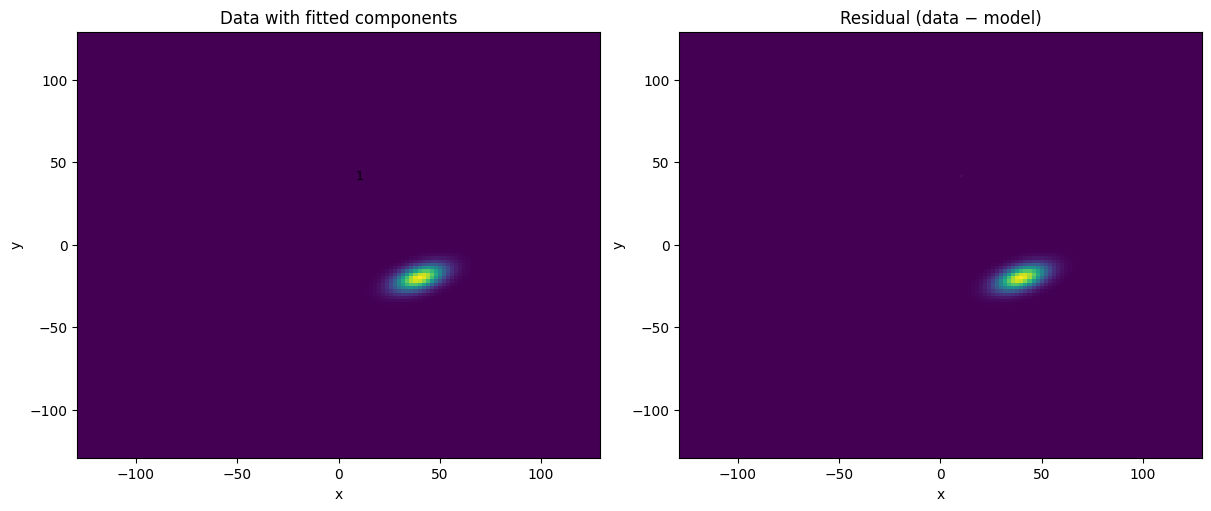

In [7]:
resid_1g = fit_1g["residual"]
print("residual min, max: ", minmax(resid_1g))
plot_components(data_1g, fit_1g, dims=("x", "y"), show_residual=True, fwhm=True)

### Two Gaussians in noiseless image

Let's add another componenet and fit two Gaussians simultaneously. We don't supply an
initial guess, so the application will determine initial guesses.

In [8]:
comp_2g = comp_1g.copy()
comp_2g.append(dict(amp=7.0, x0=-50, y0=10, fwhm_major=8.0, fwhm_minor=6.0, theta=1))

data_2g = make_scene_via_component_models(
    ny=ny,
    nx=nx,
    components=comp_2g,
    offset=0.0,
    noise_std=0,
    x_world=(-nx+1, nx-1),
    y_world=(-ny+1, ny-1),
)

components [[{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}, {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1}]] <class 'list'>
plane component {'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4} <class 'dict'>
plane component {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1} <class 'dict'>
shape z (129, 129) dims ('y', 'x')
da shape (129, 129)


In [9]:
print("the model we are fitting is", comp_2g)

# preform the fit.
fit_2g = fit_multi_gaussian2d(data_2g, n_components=2)
fit_2g

the model we are fitting is [{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}, {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1}]


<xarray.Dataset> Size: 136kB
Dimensions:                (component: 2, x: 129, y: 129)
Coordinates:
  * x                      (x) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
  * y                      (y) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
Dimensions without coordinates: component
Data variables: (12/37)
    amplitude              (component) float64 16B 0.006793 0.02291
    amplitude_err          (component) float64 16B 2.239e-08 7.798e+06
    peak                   (component) float64 16B 0.02953 0.04565
    peak_err               (component) float64 16B 0.001932 7.798e+06
    x0_pixel               (component) float64 16B 83.26 108.0
    y0_pixel               (component) float64 16B 98.57 84.48
    ...                     ...
    variance_explained     float64 8B -1.862e-08
    residual               (y, x) float64 133kB -0.02274 -0.02274 ... -0.02274
    x0_world               (component) float64 16B 38.52 87.97
    y0_world               (component) float64 16B 69.14 40.97
    x0_world_err           (component) float64 16B 1.208e-07 1.146e+08
    y0_world_err           (component) float64 16B 5.609e-08 2.247e+07
Attributes:
    axes_handedness:   right
    theta_convention:  math
    call:              fit_multi_gaussian2d(...)
    param:             {'n_components': 2, 'dims': None, 'min_threshold': Non...
    package:           astroviper
    version:           0.0.18
    fit_native_frame:  world

The min/max residual values should be on the order of 1e-14.

residual min, max:  (-0.02302857581018027, 6.977257875016953)


(<Figure size 1200x500 with 2 Axes>,
 (<Axes: title={'center': 'Data with fitted components'}, xlabel='x', ylabel='y'>,
  <Axes: title={'center': 'Residual (data − model)'}, xlabel='x', ylabel='y'>))

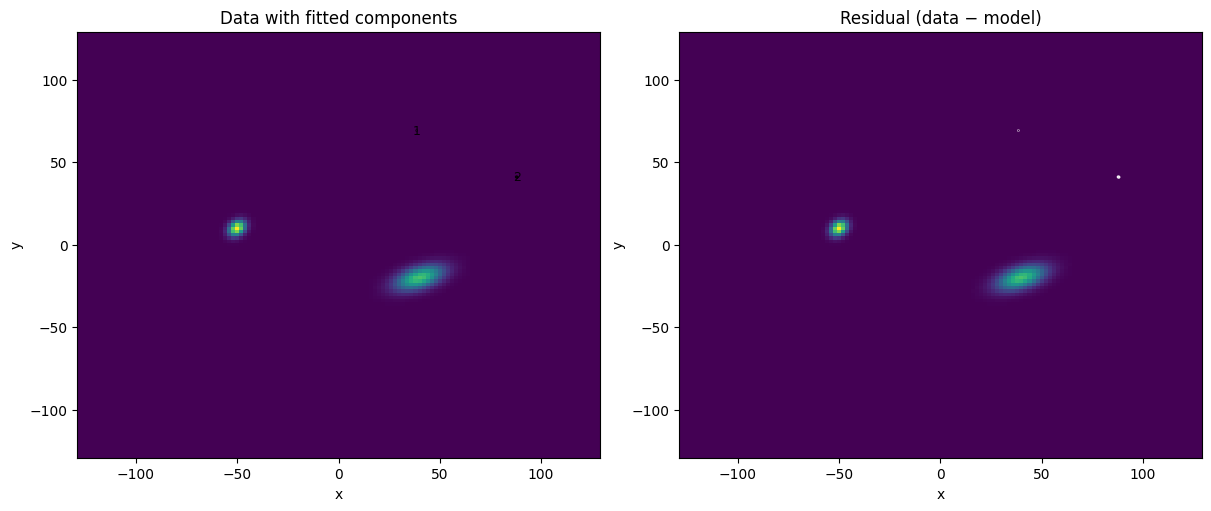

In [10]:
print("residual min, max: ", minmax(fit_2g["residual"]))
plot_components(data_2g, fit_2g, dims=("x", "y"), show_residual=True, fwhm=True)

### Fitting with noise

Now let's add some noise and fit wo the uncertainties will be more interesting

In [11]:
data_2g_noise = make_scene_via_component_models(
    ny=ny,
    nx=nx,
    components=comp_2g,
    offset=0.0,
    noise_std=0.5,
    x_world=(-nx+1, nx-1),
    y_world=(-ny+1, ny-1),
)

noise_reg = data_2g_noise[:, 0:32]
std = noise_reg.std().item()

print("noise level", std)
print("noise min, max", minmax(noise_reg))

components [[{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}, {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1}]] <class 'list'>
plane component {'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4} <class 'dict'>
plane component {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1} <class 'dict'>
shape z (129, 129) dims ('y', 'x')
da shape (129, 129)
noise level 0.49675040323127645
noise min, max (-1.8708743832256725, 1.7516187146296738)


In [12]:
print("the model we are fitting is", comp_2g)

# preform the fit.
fit_2g_noise = fit_multi_gaussian2d(data_2g_noise, n_components=2)
fit_2g_noise

the model we are fitting is [{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}, {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1}]


<xarray.Dataset> Size: 136kB
Dimensions:                (component: 2, x: 129, y: 129)
Coordinates:
  * x                      (x) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
  * y                      (y) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
Dimensions without coordinates: component
Data variables: (12/37)
    amplitude              (component) float64 16B 1.21e-20 2.233
    amplitude_err          (component) float64 16B 0.2785 375.4
    peak                   (component) float64 16B 0.02137 2.255
    peak_err               (component) float64 16B 0.2786 375.4
    x0_pixel               (component) float64 16B 79.65 107.4
    y0_pixel               (component) float64 16B 102.0 95.0
    ...                     ...
    variance_explained     float64 8B 0.000349
    residual               (y, x) float64 133kB 0.4084 -0.07039 ... 0.7728
    x0_world               (component) float64 16B 31.31 86.76
    y0_world               (component) float64 16B 76.07 61.99
    x0_world_err           (component) float64 16B 1.066e-13 37.83
    y0_world_err           (component) float64 16B 8.917e-15 1.226
Attributes:
    axes_handedness:   right
    theta_convention:  math
    call:              fit_multi_gaussian2d(...)
    param:             {'n_components': 2, 'dims': None, 'min_threshold': Non...
    package:           astroviper
    version:           0.0.18
    fit_native_frame:  world

residual min, max:  (-1.8922416585403383, 6.425788076035668)


(<Figure size 1200x500 with 2 Axes>,
 (<Axes: title={'center': 'Data with fitted components'}, xlabel='x', ylabel='y'>,
  <Axes: title={'center': 'Residual (data − model)'}, xlabel='x', ylabel='y'>))

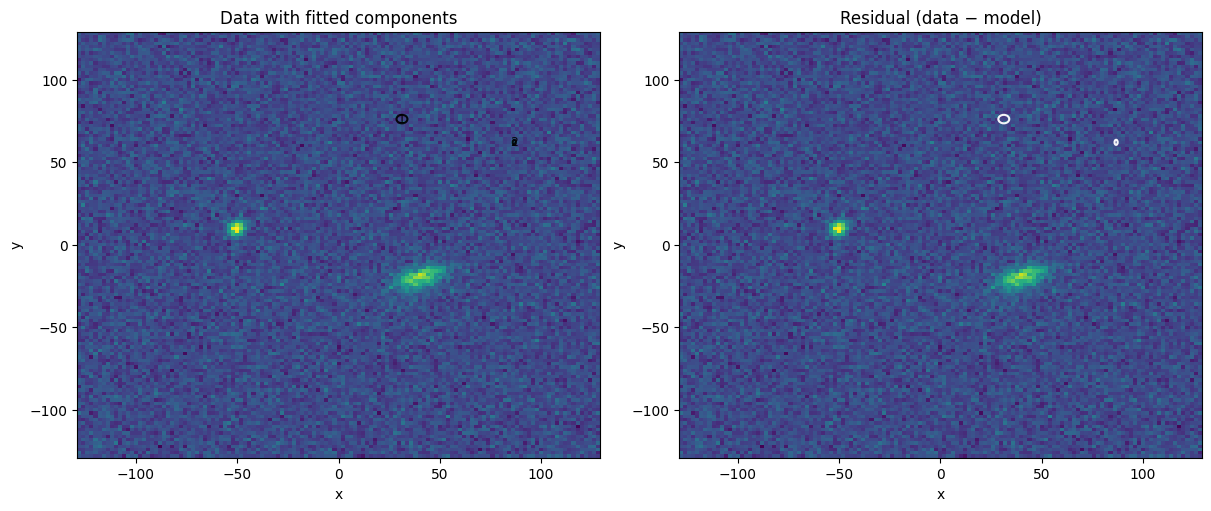

In [13]:
print("residual min, max: ", minmax(fit_2g_noise["residual"]))
plot_components(data_2g_noise, fit_2g_noise, dims=("x", "y"), show_residual=True, fwhm=True)

### Fitting over multiple planes

One can simultaneously fit each plane of a >2D image, if all planes have the same number of components to fit. Here we simultaneously fit to both planes of an array with shape (nx, ny, 2).

In [14]:
plane_0_model = comp_2g.copy()
plane_1_model = [
    dict(amp=7.0, x0=-70, y0=-30, fwhm_major=20.0, fwhm_minor=15.0, theta=0.5),
    dict(amp=11.0, x0=28, y0=15.5, fwhm_major=15.6, fwhm_minor=10.0, theta=1.2)
]

comp_2p = (plane_0_model, plane_1_model)

data_2p = make_scene_via_component_models(
    ny=ny,
    nx=nx,
    components=comp_2p,
    offset=0.0,
    noise_std=0.5,
    x_world=(-nx+1, nx-1),
    y_world=(-ny+1, ny-1),
)

components ([{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}, {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1}], [{'amp': 7.0, 'x0': -70, 'y0': -30, 'fwhm_major': 20.0, 'fwhm_minor': 15.0, 'theta': 0.5}, {'amp': 11.0, 'x0': 28, 'y0': 15.5, 'fwhm_major': 15.6, 'fwhm_minor': 10.0, 'theta': 1.2}]) <class 'tuple'>
plane component {'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4} <class 'dict'>
plane component {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1} <class 'dict'>
plane component {'amp': 7.0, 'x0': -70, 'y0': -30, 'fwhm_major': 20.0, 'fwhm_minor': 15.0, 'theta': 0.5} <class 'dict'>
plane component {'amp': 11.0, 'x0': 28, 'y0': 15.5, 'fwhm_major': 15.6, 'fwhm_minor': 10.0, 'theta': 1.2} <class 'dict'>
shape z (129, 129, 2) dims ('y', 'x', 'z')
da shape (129, 129, 2)


In [15]:
print("the model we are fitting is", comp_2p)

# preform the fit.
fit_2p = fit_multi_gaussian2d(data_2p, n_components=2)
fit_2p

the model we are fitting is ([{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}, {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1}], [{'amp': 7.0, 'x0': -70, 'y0': -30, 'fwhm_major': 20.0, 'fwhm_minor': 15.0, 'theta': 0.5}, {'amp': 11.0, 'x0': 28, 'y0': 15.5, 'fwhm_major': 15.6, 'fwhm_minor': 10.0, 'theta': 1.2}])


<xarray.Dataset> Size: 269kB
Dimensions:                (z: 2, component: 2, x: 129, y: 129)
Coordinates:
  * z                      (z) float64 16B 2.0 4.0
  * x                      (x) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
  * y                      (y) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
Dimensions without coordinates: component
Data variables: (12/37)
    amplitude              (z, component) float64 32B 0.6758 1.129 1.715 11.08
    amplitude_err          (z, component) float64 32B 0.2265 8.695e+07 ... 0.186
    peak                   (z, component) float64 32B 0.6958 1.149 1.756 11.12
    peak_err               (z, component) float64 32B 0.2266 ... 0.1861
    x0_pixel               (z, component) float64 32B 80.17 106.0 99.55 77.97
    y0_pixel               (z, component) float64 32B 92.56 90.26 104.5 71.71
    ...                     ...
    variance_explained     (z) float64 16B 0.001775 0.298
    residual               (z, y, x) float64 266kB -0.9493 0.9306 ... -0.2706
    x0_world               (z, component) float64 32B 32.34 83.94 71.1 27.93
    y0_world               (z, component) float64 32B 57.11 52.52 80.96 15.41
    x0_world_err           (z, component) float64 32B 2.311 ... 0.07693
    y0_world_err           (z, component) float64 32B 2.372 4.697e+08 ... 0.1046
Attributes:
    axes_handedness:   right
    theta_convention:  math
    call:              fit_multi_gaussian2d(...)
    param:             {'n_components': 2, 'dims': None, 'min_threshold': Non...
    package:           astroviper
    version:           0.0.18
    fit_native_frame:  world

Plot both planes using the **indexer** param to indicate which plane to plot.

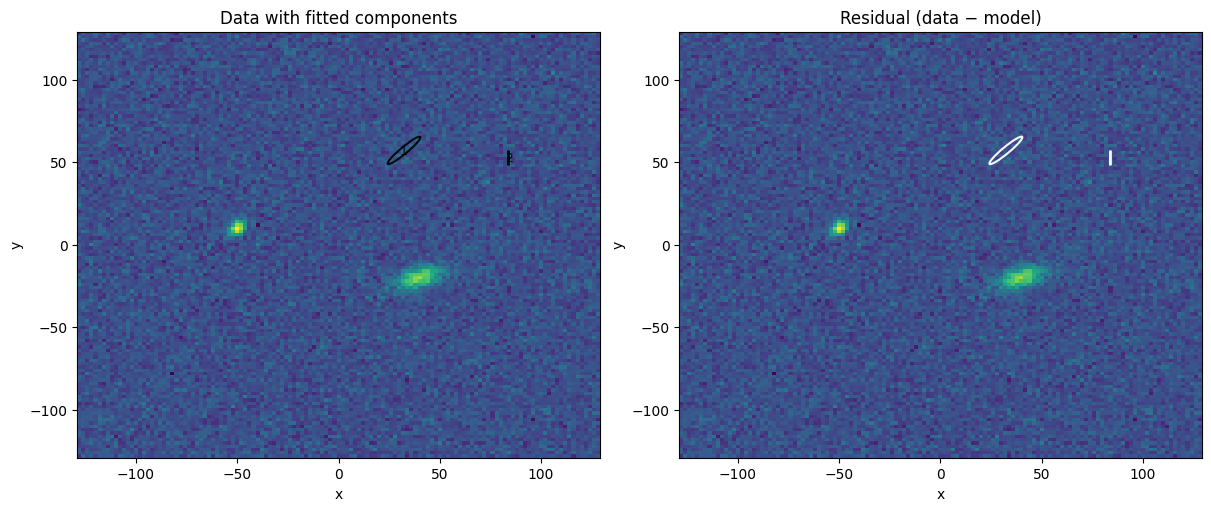

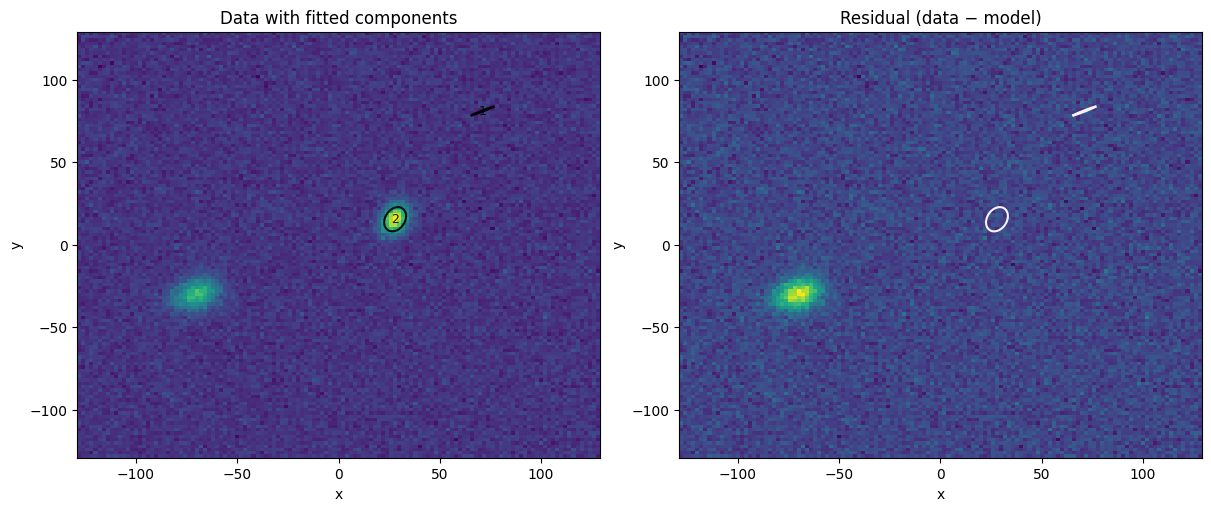

In [16]:
plot_components(data_2p, fit_2p, dims=("x", "y"), show_residual=True, fwhm=True, indexer=dict(z=0))
junk=plot_components(data_2p, fit_2p, dims=("x", "y"), show_residual=True, fwhm=True, indexer=dict(z=1))

## Threshold masking
The application supports thresholding, so that pixels outside inclusive `[min_threshold, max_threshold]` are ignored during the fit.

In [17]:
print("We are fitting to thess models:", comp_2g)
fit_thr = fit_multi_gaussian2d(
    data_2g_noise, n_components=2, min_threshold=0.4, max_threshold=None
)
print(f"\n{"Comparison of thresholded vs non-thresholded fits".upper():^100}")
print(f"{"Results with threshold":>42} \t\tResults without threshold\n")
for k in (
    "amplitude", "peak", "offset", "x0_world", "y0_world",
    "fwhm_major_world", "fwhm_minor_world", "theta_world"
):
    v, e = round_for_display(
        fit_thr[k].values, fit_thr[k+"_err"].values, sig=2, as_string=False
    )
    v1, e1 = round_for_display(
        fit_2g_noise[k].values, fit_2g_noise[k+"_err"].values, sig=2, as_string=False
    )
    print(f"{k:<18}{str(v):>18} \u00B1 {str(e):<13} {str(v1):>18} \u00B1 {str(e1):<20}")
print(
    "\nNote that the offset is signiificantly higher in the thresholded fit "
    "because of the omission of lower values"
)
fit_thr

We are fitting to thess models: [{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}, {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1}]

                         COMPARISON OF THRESHOLDED VS NON-THRESHOLDED FITS                          
                    Results with threshold 		Results without threshold

amplitude                    [0. 0.] ± [  96000. 8300000.]            [0. 0.] ± [2.8e-01 3.8e+02]   
peak                         [0. 0.] ± [  96000. 8300000.]        [0.02 0.  ] ± [2.8e-01 3.8e+02]   
offset                        0.7413 ± 0.008                     0.0214 ± 0.0043              
x0_world                     [0. 0.] ± [3.4e+04 9.4e+07] [31.30539802 87.        ] ± [1.1e-13 3.8e+01]   
y0_world                     [0. 0.] ± [   26000. 22000000.] [76.06549151 62.        ] ± [8.9e-15 1.2e+00]   
fwhm_major_world             [0. 0.] ± [  100000. 45000000.] [5.40061203 3.1       ] ± [3.0e-13 1.5e+00]  

<xarray.Dataset> Size: 136kB
Dimensions:                (component: 2, x: 129, y: 129)
Coordinates:
  * x                      (x) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
  * y                      (y) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
Dimensions without coordinates: component
Data variables: (12/37)
    amplitude              (component) float64 16B 1.051 0.5666
    amplitude_err          (component) float64 16B 9.576e+04 8.326e+06
    peak                   (component) float64 16B 1.793 1.308
    peak_err               (component) float64 16B 9.576e+04 8.326e+06
    x0_pixel               (component) float64 16B 81.23 111.4
    y0_pixel               (component) float64 16B 100.2 90.13
    ...                     ...
    variance_explained     float64 8B 0.000548
    residual               (y, x) float64 133kB -0.3115 -0.7903 ... 0.0528
    x0_world               (component) float64 16B 34.45 94.79
    y0_world               (component) float64 16B 72.41 52.27
    x0_world_err           (component) float64 16B 3.394e+04 9.443e+07
    y0_world_err           (component) float64 16B 2.564e+04 2.206e+07
Attributes:
    axes_handedness:   right
    theta_convention:  math
    call:              fit_multi_gaussian2d(...)
    param:             {'n_components': 2, 'dims': None, 'min_threshold': 0.4...
    package:           astroviper
    version:           0.0.18
    fit_native_frame:  world

## Initial guesses formats
Forms:
- **Array (N,6)** — used above.
- **List of N dicts** — supports key synonyms.
- **Dict with `"components"`** — optional `"offset"` seed.
Angles in `initial_guesses` are interpreted per `angle=`.

In [18]:
# print("We are fitting to these models: ", comp_2g)

# (a) array(N, 6).
# The order is [amplitude, x0, y0, fwhm_major, fwhm_minor, theta]
init_arr = [
    [5.5, 41.0, -22.5, 15.0, 8.0, 0.3],
    [8.5, -56.0, 8.5, 6.0, 4.5, 0.9],
]
ds_arr = fit_multi_gaussian2d(data_2g_noise, n_components=2, initial_guesses=init_arr)


# (b) list of dicts
init_list = [
    {"amp": 5.5, "x0": 41.0, "y0": -22.5, "fwhm_major": 15.0, "fwhm_minor": 8.0, "theta": 0.3},
    {"amplitude": 8.5, "x0": -56.0, "y0": 8.5, "sx": 7.0, "sy": 5.2, "theta": 0.9},
]
ds_list = fit_multi_gaussian2d(data_2g_noise, n_components=2, initial_guesses=init_list)

# (c) dict with 'components' and 'offset'
init_dict = {"offset": 0.12, "components": init_arr}
ds_dict = fit_multi_gaussian2d(data_2g_noise, n_components=2, initial_guesses=init_dict)

None

In [19]:
print("We are fitting to these models: ", comp_2g)

title = "COMPARISON OF RESULTS FOR THE THREE FORMATS"
keys = (
    "amplitude", "peak", "offset", "x0_world", "y0_world",
    "fwhm_major_world", "fwhm_minor_world", "theta_world"
)

def _fmt_cell(key, val):
    a = np.asarray(val)
    if key == "offset":
        if a.shape == () or a.size == 1:
            return f"{a.astype(float).item():.4f}"
        return "[" + ", ".join(f"{x:.2f}" for x in a.ravel()) + "]"
    return "[" + ", ".join(f"{x:.2f}" for x in a.ravel()) + "]"

rows = []
for k in keys:
    rows.append((
        k,
        _fmt_cell(k, ds_arr[k]),
        _fmt_cell(k, ds_list[k]),
        _fmt_cell(k, ds_dict[k]),
    ))

headers = ("Variable", "Array", "List", "Dict")
w0 = max(len(headers[0]), max(len(r[0]) for r in rows))
w1 = max(len(headers[1]), max(len(r[1]) for r in rows))
w2 = max(len(headers[2]), max(len(r[2]) for r in rows))
w3 = max(len(headers[3]), max(len(r[3]) for r in rows))

sep = f"+-{'-'*w0}-+-{'-'*w1}-+-{'-'*w2}-+-{'-'*w3}-+"
header = f"| {headers[0]:<{w0}} | {headers[1]:<{w1}} | {headers[2]:<{w2}} | {headers[3]:<{w3}} |"

total_width = len(sep)
print("\n" + title.center(total_width) + "\n")
print(sep)
print(header)
print(sep)
for k, c1, c2, c3 in rows:
    print(f"| {k:<{w0}} | {c1:<{w1}} | {c2:<{w2}} | {c3:<{w3}} |")
print(sep)

We are fitting to these models:  [{'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}, {'amp': 7.0, 'x0': -50, 'y0': 10, 'fwhm_major': 8.0, 'fwhm_minor': 6.0, 'theta': 1}]

               COMPARISON OF RESULTS FOR THE THREE FORMATS                

+------------------+-----------------+-----------------+-----------------+
| Variable         | Array           | List            | Dict            |
+------------------+-----------------+-----------------+-----------------+
| amplitude        | [4.95, 6.72]    | [4.95, 6.72]    | [4.95, 6.72]    |
| peak             | [4.95, 6.72]    | [4.95, 6.72]    | [4.95, 6.72]    |
| offset           | -0.0017         | -0.0017         | -0.0017         |
| x0_world         | [40.24, -50.16] | [40.24, -50.16] | [40.24, -50.16] |
| y0_world         | [-19.80, 9.89]  | [-19.80, 9.89]  | [-19.80, 9.89]  |
| fwhm_major_world | [20.68, 7.82]   | [20.68, 7.82]   | [20.68, 7.82]   |
| fwhm_minor_world | [10.04, 6.39]   | [

# TODO Rewrite
Below here needs rewriting. As is things are likely to break.

## 5) Bounds (and fixing parameters)
- Dict mapping names → `(low, high)` **or** per-component list of tuples.
- To **fix** a value, use equal bounds `(v, v)`.

bounds_all = {"amplitude": (0.4, 1.5)}
bounds_per = {"sigma_x": [(2.5, 3.5), (4.0, 6.0)]}

ds_bounds_all = fit_multi_gaussian2d(img, n_components=2, initial_guesses=init_arr, bounds=bounds_all)
ds_bounds_per = fit_multi_gaussian2d(img, n_components=2, initial_guesses=init_arr, bounds=bounds_per)

ds_fix_offset = fit_multi_gaussian2d(
    img, n_components=2, initial_guesses=init_arr, bounds={"offset": (0.12, 0.12)}
)
float(ds_fix_offset.offset)

## 6) Return model and residual
- `return_model=True` → `ds["model"]`
- `return_residual=True` → `ds["residual"] = data - model`

ds_planes = fit_multi_gaussian2d(
    img, n_components=2, initial_guesses=init_arr, return_model=True, return_residual=True
)
ds_planes["model"], ds_planes["residual"]

## 7) Angle conventions: `"math"`, `"pa"`, `"auto"`
- `"math"`: θ from +x → +y (CCW) in data axes.
- `"pa"`: position angle from +y → +x.
- `"auto"`: detect left-handed axes (descending/ascending) and use PA; else math.
Inputs interpret `theta` per `angle`, outputs reported in the same convention.

# Fit with PA conventions; seeds given in PA
pa_init = [{
    "amp": 1.0, "x0": 42.0, "y0": 60.0, "sigma_x": 3.0, "sigma_y": 2.2,
    "theta": float(np.arctan2(np.cos(0.5), np.sin(0.5)))
}]
ds_pa = fit_multi_gaussian2d(img, n_components=1, initial_guesses=pa_init, angle="pa")
float(ds_pa.theta)

# AUTO: make a left-handed grid by flipping 'y' coords; AUTO chooses PA here
img_desc_y = img.assign_coords(y=img.y.values[::-1])
ds_auto = fit_multi_gaussian2d(img_desc_y, n_components=1, initial_guesses=pa_init, angle="auto")
float(ds_auto.theta)

## 8) Vectorized fitting over extra dims
N-D inputs are fit per-plane across all leading dims; specify plane dims with `dims=("x","y")` if needed.

planes = [img + 0.01 * rng.normal(size=img.shape) for _ in range(3)]
cube = xr.concat(planes, dim="time")  # dims: ('time','y','x')

ds_cube = fit_multi_gaussian2d(cube, n_components=2, initial_guesses=init_arr, dims=("x", "y"))
ds_cube

## 9) Dask-backed arrays
Accepts Dask arrays and parallelizes via `xarray.apply_ufunc(dask="parallelized")`.

cube_np = np.stack([(img + 0.01 * rng.normal(size=img.shape)).values for _ in range(4)], axis=0)
cube_da = xr.DataArray(da.from_array(cube_np, chunks=(2, img.shape[0], img.shape[1])), dims=("time", "y", "x"))

ds_dask = fit_multi_gaussian2d(cube_da, n_components=2, initial_guesses=init_arr, dims=("x", "y"))
float(ds_dask["amplitude"].mean().compute())

## 10) World coordinates of centroids
If both fit axes have 1-D numeric coords, results include `x_world(component)` and `y_world(component)`.

("x_world" in ds_basic and "y_world" in ds_basic), ds_basic.get("x_world"), ds_basic.get("y_world")

## 11) Error handling & tips
- `n_components` ≥ 1.
- N-D arrays without `(\"x\",\"y\")` dims: pass `dims=(x_dim, y_dim)`.
- Initial guesses length/shape must match `n_components`.
- Bounds: per-component list must be length N; to fix a value, use `(v, v)`.
- Performance: reasonable seeds & tight bounds; adjust `max_nfev`; with Dask, tune chunking/scheduler.